In [1]:
## -----------IMPORT LIBRARIES
import pandas as pd #for dealing with csv import
import os # for joining paths and filenames sensibly
import numpy as np #for the population std
import glob # for finding csv data Çfiles
import platform # paths use different dividers on linux vs windows, so we need to test for this
import csv

In [2]:
path_folder = 'C:\\Users\\David\\Desktop\\OpenBrains\\biased_brains'

exclude_ = ['coles', 'data', 'eyetracker_recordings', 'guinardo_all', 'juncar_all', 'other', 'implicit_bias_imerys' ]

folders = os.listdir(path_folder)

os.listdir(path_folder)

['coles',
 'data',
 'eyetracker_recordings',
 'guinardo_all',
 'guinardo_all2',
 'guinardo_bt',
 'guinaueta',
 'implicit_bias_imerys',
 'juncar_1',
 'juncar_2',
 'juncar_all',
 'maristes',
 'marti_pous',
 'Moli',
 'Moli_bt',
 'other',
 'PiaBalaguer',
 'Pias_sc',
 'Pias_sc_3D',
 'Pias_sc_bt']

In [3]:
folder_ = set(folders) - set(exclude_)
folders_correct = list(folder_)
folders_correct

['Moli_bt',
 'maristes',
 'marti_pous',
 'guinaueta',
 'juncar_1',
 'guinardo_all2',
 'Pias_sc_bt',
 'Pias_sc',
 'guinardo_bt',
 'Pias_sc_3D',
 'Moli',
 'juncar_2',
 'PiaBalaguer']

In [4]:
all_files = []
all_names = []

for idx,fold in enumerate(folders_correct):
    files_ = os.path.join(path_folder, folders_correct[idx])
    search_string=os.path.join(files_,'*.csv') 
    files = glob.glob(search_string)
    names_ = [fold for i in range(len(files))]
    all_names.append(names_)
    all_files.append(files)

    
files = [item for sublist in all_files for item in sublist]
names = [item for sublist in all_names for item in sublist]


In [5]:
len(files)
len(names)

479

In [6]:
### Functions
def adjustedmean(RTs,corrs,penalty):
    n=len(corrs) #trials
    n_errors=n-sum(corrs) #errors
    cor_RTs=np.array(corrs)*RTs #sum of correct RTs
    cor_mean=sum(cor_RTs)/sum(corrs)
    import csv
    #mean with errors replaced with penalty value
    return cor_mean+(n_errors*penalty)/n

###

def exclude_slows(RTs,corrs,slowRT_limit):
    new_rt=[] #holding variables
    new_cr=[]
    for i in range(len(RTs)): #iterate over every item
        if RTs[i] < slowRT_limit: #if it isn't too fast, include RT and corr values
            new_rt.append(RTs[i])
            new_cr.append(corrs[i])
    
    return (new_rt, new_cr)

In [7]:
## -----------DEFINE PARAMETERS
penalty=0.600 #penalty - in seconds - for incorrect responses
slowRT_limit=10 #threshold at which slow RTs are discarded
fastRT_limit=0.300 #threshold which defines responses which are "too fast"
fast_prop_limit=0.1 # threshold proportion of "too fast" responses which defines exclusion of ppt

In [8]:
#now iterate through all data files and calculate the IAT  

summary=[]

for idx_f, filename in enumerate(files):
    code_ =filename.split('\\')[-1].split('_')[1]
    print(filename.split('\\')[-1].split('_')[2])
    print(code_)
    file_path =os.path.join(path_folder,filename) 

    #import into python using pandas
    try:
        df = pd.read_csv(file_path)
        df['centre'] = names[idx_f]
    except pd.io.common.EmptyDataError:
        print('not enough data')
        continue
        
    ####   
    if len(df)<10:
        print('not enough data')
        continue
            
    ## -----------EXTRACT DATA
    #find order 
    order=df['order'].tolist()[0]
    #1 congr then incong
    #2 incongr then congr

    if order==1:
        congr_corr=   df['corr'][24:44].dropna().tolist()  #corrs[0:block_length]
        congr_rts=    df['rt'][24:44].dropna().tolist()   #rts[0:block_length]
        incon_corr=   df['corr'][56:].dropna().tolist() #corrs[block_length:]
        incon_rts=    df['rt'][56:].dropna().tolist()    #rts[block_length:]
    else:
        congr_corr= df['corr'][56:].dropna().tolist()  #corrs[block_length:]
        congr_rts= df['rt'][56:].dropna().tolist() #rts[block_length:]
        incon_corr= df['corr'][24:44].dropna().tolist() #corrs[0:block_length]
        incon_rts= df['rt'][24:44].dropna().tolist() #rts[0:block_length]
            
    
    
    ## -----------ANALYSE / CALCULATE
        
    #1 discard subject if too many fast responses
    if sum(np.array(congr_rts + incon_rts)<fastRT_limit)>len(congr_rts + incon_rts)*fast_prop_limit:
        print("excluding subject for " + code_ + " because too many fast responses")
    else:
        #2 Eliminate scores over 10,000 ms
             
        congr_rts,congr_corr=exclude_slows(congr_rts,congr_corr,slowRT_limit)              
        incon_rts,incon_corr=exclude_slows(incon_rts,incon_corr,slowRT_limit)
        
        #3 Calculate pooled std
        #pooled_std=pooled.std(0) #n-1 std sample std
        #(Use N not N-1 because this is the whole sample). 
        #numpy.std is population std
        pooled=congr_rts + incon_rts #all RTs from both blocks, correct and incorrect
        pooled_std=np.std(pooled)
        
        #4 Calculated adjusted means, including the penalty
        congr_adjmean=adjustedmean(congr_rts,congr_corr,penalty)
        incon_adjmean=adjustedmean(incon_rts,incon_corr,penalty)
        
        #5 Calculate the IAT, so that pro-stereotype RTs are a -ve score
        IAT=(congr_adjmean-incon_adjmean)/pooled_std
        
        simpleIAT=np.mean(congr_rts)-np.mean(incon_rts)        
        
        print("IAT is : {:+.3f}".format(IAT))
        print('')
        #print("Mean difference (uncorrected) is {:+.3f}".format(simpleIAT)+" seconds")
        #datwriter.writerow(['IAT score', 'raw uncorrected', 'congruent mean RT,'congruent RT sd', 'congruent error prop','incongruent mean RT,'incongruent RT sd', 'incongruent error prop'])            
        summary.append([df.gender.iloc[0], 
                        df.centre.iloc[0], 
                        code_,
                        "{:+.3f}".format(IAT), 
                        "{:+.3f}".format(simpleIAT), 
                        "{:+.3f}".format(np.mean(congr_rts)),
                        "{:+.3f}".format(np.std(congr_rts)),
                        "{:+.2f}".format(1-(sum(congr_corr)/len(congr_corr))),
                        "{:+.3f}".format(np.mean(incon_rts)),
                        "{:+.3f}".format(np.std(incon_rts)),
                        "{:+.2f}".format(1-(sum(incon_corr)/len(incon_corr))),
                        "{:+.3f}".format(congr_adjmean),
                        "{:+.3f}".format(incon_adjmean)])            
        # np.std(congr_rts)
        # sum(congr_corr)/size(congr_corr)
    







2023-05-03
openIAT
IAT is : -1.698

2023-05-03
openIAT
IAT is : -1.217

2023-05-03
openIAT
IAT is : -1.113

2023-05-03
openIAT
IAT is : +0.319

openIAT
amg
IAT is : -1.580

openIAT
jeta
IAT is : +0.007

openIAT
KSK
IAT is : -0.352

openIAT
MPV
IAT is : -0.393

openIAT
oe
IAT is : -0.706

openIAT
OGP
IAT is : -1.606

openIAT
RBI
IAT is : -1.126

openIAT
sea
IAT is : -1.014

openIAT
YH
IAT is : -0.952

openIAT
ypj
IAT is : -1.009

openIAT
AC
IAT is : +0.054

openIAT
Ainara
IAT is : -1.425

openIAT
A
IAT is : -0.986

openIAT
DanielRodriguez
IAT is : -1.510

openIAT
David
IAT is : -2.003

openIAT
ERM
IAT is : -0.831

openIAT
GGG
IAT is : -0.700

openIAT
GHV
IAT is : -0.755

openIAT
JRR
IAT is : +0.128

openIAT
julen
IAT is : -1.000

openIAT
LS
IAT is : -0.188

openIAT
Marc
IAT is : -0.905

openIAT
MTH
IAT is : -0.771

openIAT
RubenL
IAT is : -0.695

openIAT
Samu
IAT is : -0.861

openIAT
Sergi
IAT is : -1.945

openIAT
TL
IAT is : -1.725

openIAT
XXXMerce
IAT is : -0.817

openIAT
XXX
IAT is 

IAT is : -0.941

ISG
sc
IAT is : -1.173

jcc
sc
IAT is : -0.800

MW
sc
IAT is : +0.439

RDM
sc
IAT is : +0.197

XXX
sc
IAT is : -0.310

xxx
sc
IAT is : -0.964

ACM
sc
IAT is : -0.260

AJB
sc
IAT is : -0.920

AMG
sc
IAT is : -0.121

ARR
sc
IAT is : -0.403

CAG
sc
IAT is : -1.136

CLB
sc
IAT is : -0.882

CLB
sc
IAT is : -0.983

ETP
sc
IAT is : -1.018

JCG
sc
IAT is : -1.240

LAB
sc
IAT is : -0.165

MDV
sc
IAT is : -1.497

MGL
sc
excluding subject for sc because too many fast responses
MLR
sc
IAT is : -0.897

MMF
sc
IAT is : -0.915

NCN
sc
IAT is : -0.953

OCG
sc
IAT is : -0.684

PRM
sc
IAT is : -1.768

VGP
sc
IAT is : -0.857

AAS
sc
IAT is : -0.262

ABY
sc
IAT is : -0.803

afp
sc
IAT is : +0.024

AGN
sc
IAT is : -0.387

BMR
sc
IAT is : -1.497

GAM
sc
IAT is : -0.717

GST
sc
IAT is : -1.648

ICC
sc
IAT is : -0.716

IGM
sc
IAT is : -1.273

LCJ
sc
IAT is : +0.617

LRD
sc
IAT is : -1.030

MBP
sc
IAT is : -1.227

MOR
sc
IAT is : -0.415

OGC
sc
IAT is : -1.067

PCG
sc
IAT is : -0.177

AGR
sc
e

In [9]:
iat_race=pd.DataFrame(summary)
iat_race.columns = ['genero', 'centro','file_code', 'IAT score', 'raw uncorrected', 'congruent mean RT','congruent RT sd', 'congruent error prop','incongruent mean RT','incongruent RT sd', 'incongruent error prop', 'congruent adjmean RT', 'incongruent adjmean RT' ]           
#iat_race.to_csv(path_summary_file + 'summary_filex.csv')  

In [10]:
iat_race['congruent mean RT'] =  iat_race['congruent mean RT'].astype(float)
iat_race['incongruent mean RT'] =  iat_race['incongruent mean RT'].astype(float)
iat_race['congruent adjmean RT'] =  iat_race['congruent adjmean RT'].astype(float)
iat_race['incongruent adjmean RT'] =  iat_race['incongruent adjmean RT'].astype(float)

In [11]:
iat_race['cmcs'] = (iat_race['centro'] =='marti_pous') + (iat_race['centro'] =='Moli') + (iat_race['centro'] =='Moli_bt')  + (iat_race['centro'] =='guinaueta')

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  op=op_str, alt_op=unsupported[op_str]


In [12]:
iat_race

,genero,centro,file_code,IAT score,raw uncorrected,congruent mean RT,congruent RT sd,congruent error prop,incongruent mean RT,incongruent RT sd,incongruent error prop,congruent adjmean RT,incongruent adjmean RT,cmcs
0,male,Moli_bt,openIAT,-1.698,-0.538,0.717,+0.316,+0.10,1.256,+0.385,+0.29,0.792,1.532,True
1,male,Moli_bt,openIAT,-1.217,-0.525,0.677,+0.147,+0.00,1.203,+0.584,+0.07,0.677,1.248,True
2,male,Moli_bt,openIAT,-1.113,-0.415,0.560,+0.114,+0.10,0.975,+0.659,+0.21,0.634,1.166,True
3,male,Moli_bt,openIAT,+0.319,+0.400,1.827,+1.075,+0.05,1.427,+0.975,+0.29,1.921,1.584,True
4,male,Moli_bt,amg,-1.580,-0.404,0.683,+0.136,+0.00,1.087,+0.191,+0.00,0.683,1.087,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,female,PiaBalaguer,JMT,-0.858,-0.227,0.607,+0.268,+0.10,0.834,+0.305,+0.14,0.685,0.947,False
458,female,PiaBalaguer,LBC,-1.118,-0.183,0.760,+0.298,+0.00,0.943,+0.316,+0.21,0.760,1.117,False
459,male,PiaBalaguer,MYD,-0.496,-0.113,0.772,+0.286,+0.05,0.885,+0.427,+0.14,0.807,0.983,False
460,male,PiaBalaguer,openIAT,-1.347,-0.163,0.425,+0.152,+0.15,0.588,+0.128,+0.21,0.515,0.735,False


## PLOTS

In [15]:
import pandas as pd #for dealing with csv import
import matplotlib.pyplot as plt  # Matplotlib's pyplot: MATLAB-like syntax
import scipy
from scipy import stats
import numpy as np
import seaborn as sns

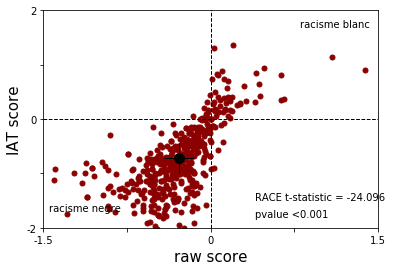

In [40]:
iat_scores = iat_race['IAT score'].values
iat_scores = iat_scores.astype(np.float)

raw_uncorrected = iat_race['raw uncorrected'].values
raw_uncorrected = raw_uncorrected.astype(np.float)


plt.figure()

for i in range(len(iat_scores)):
    plt.plot(raw_uncorrected[i], iat_scores[i],marker='.', markersize=10, color='darkred' )

    
#
plt.xlim([-1.5,1.5])
plt.xticks([-1.5, -0.75, 0, 0.75, 1.5], ['-1.5', '', '0', '', '1.5'], fontsize=10)

plt.plot([-1.5, 1.5], [0,0], 'k--', linewidth=1)


plt.ylim([-2,2])
plt.yticks([-2,-1, 0, 1,2], ['-2','', '0', '','2'], fontsize=10)

plt.plot( [0,0], [-2,2], 'k--', linewidth=1)
plt.xlabel('raw score', fontsize=15)
plt.ylabel('IAT score', fontsize=15)

plt.plot(np.mean(raw_uncorrected), np.mean(iat_scores), marker='+', markersize=30, color='k' )
plt.plot(np.mean(raw_uncorrected), np.mean(iat_scores), marker='.', markersize=20, color='k' )

stats1 = stats.ttest_1samp(iat_scores, 0)

plt.text( 0.4, -1.5, 'RACE t-statistic = ' + str(np.round(stats1[0], 3)), fontsize=10 )

if stats1[1]<0.001:
    plt.text( 0.4, -1.8, 'pvalue <0.001', fontsize=10 )
else:
    plt.text( 0.4, -1.8, 'pvalue = ' +  str(np.round(stats1[1], 2)), fontsize=10 )


plt.text( 0.8, 1.7, 'racisme blanc' , fontsize=10 )
plt.text( -1.45, -1.7, 'racisme negre' , fontsize=10 )

plt.show(block=False)


In [34]:
iat_race.loc[iat_race['cmcs']==True, 'IAT score'].values.astype(np.float)

array([-1.698, -1.217, -1.113,  0.319, -1.58 ,  0.007, -0.352, -0.393,
       -0.706, -1.606, -1.126, -1.014, -0.952, -1.009, -0.45 , -0.374,
       -1.112, -0.025, -0.623, -0.944, -1.335,  0.049, -1.399, -0.51 ,
       -1.275,  0.359, -0.288, -0.956, -0.977, -2.083,  0.171, -1.416,
       -1.143, -1.077, -1.521, -0.623, -0.695, -1.373, -0.229, -0.817,
       -0.177, -1.374,  0.15 , -0.916,  0.404, -0.225,  0.407, -0.291,
       -0.766, -0.733,  0.338, -1.812, -1.064, -1.284, -1.135, -1.044,
       -1.69 ,  0.172,  0.506, -1.279, -0.938, -0.22 ,  0.289, -1.445,
       -1.515, -1.026, -1.888, -1.718, -0.076, -0.438,  0.339,  0.102,
       -0.616, -0.597, -1.27 ,  0.053, -1.198, -0.467, -0.791, -0.893,
       -1.44 , -1.193, -0.45 , -0.648, -0.25 , -0.787, -0.563, -1.107,
        0.127, -0.389, -1.587, -0.502,  0.023, -0.586, -0.679, -1.193,
       -1.039, -1.592,  0.272, -0.844, -0.626, -1.313, -0.894, -0.287,
       -1.64 , -1.033, -1.37 , -0.79 , -0.595, -0.54 , -0.55 , -0.867,
      

## cmcs

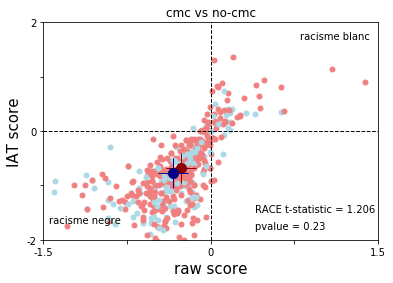

In [48]:
iat_scores = iat_race['IAT score'].values
iat_scores = iat_scores.astype(np.float)
cmcs_list = iat_race.cmcs.values

raw_uncorrected = iat_race['raw uncorrected'].values
raw_uncorrected = raw_uncorrected.astype(np.float)


plt.figure()

for i in range(len(iat_scores)):
    if cmcs_list[i]==False:
        plt.plot(raw_uncorrected[i], iat_scores[i],marker='.', markersize=10, color='lightcoral' )
    if cmcs_list[i]==True:
        plt.plot(raw_uncorrected[i], iat_scores[i],marker='.', markersize=10, color='lightblue' )

    
#
plt.xlim([-1.5,1.5])
plt.xticks([-1.5, -0.75, 0, 0.75, 1.5], ['-1.5', '', '0', '', '1.5'], fontsize=10)

plt.plot([-1.5, 1.5], [0,0], 'k--', linewidth=1)


plt.ylim([-2,2])
plt.yticks([-2,-1, 0, 1,2], ['-2','', '0', '','2'], fontsize=10)

plt.plot( [0,0], [-2,2], 'k--', linewidth=1)
plt.xlabel('raw score', fontsize=15)
plt.ylabel('IAT score', fontsize=15)



iat_scores_no_cmcs = iat_race.loc[iat_race['cmcs']==False, 'IAT score'].values.astype(np.float)
iat_scores_cmcs = iat_race.loc[iat_race['cmcs']==True, 'IAT score'].values.astype(np.float)

raw_uncorrected_no_cmcs = iat_race.loc[iat_race['cmcs']==False, 'raw uncorrected'].values.astype(np.float)
raw_uncorrected_cmcs = iat_race.loc[iat_race['cmcs']==True, 'raw uncorrected'].values.astype(np.float)

plt.plot(np.mean(raw_uncorrected_no_cmcs), np.mean(iat_scores_no_cmcs), marker='+', markersize=30, color='darkred' )
plt.plot(np.mean(raw_uncorrected_no_cmcs), np.mean(iat_scores_no_cmcs), marker='.', markersize=20, color='darkred' )

plt.plot(np.mean(raw_uncorrected_cmcs), np.mean(iat_scores_cmcs), marker='+', markersize=30, color='darkblue' )
plt.plot(np.mean(raw_uncorrected_cmcs), np.mean(iat_scores_cmcs), marker='.', markersize=20, color='darkblue' )


stats1 = stats.ttest_ind(iat_scores_no_cmcs, iat_scores_cmcs)

plt.text( 0.4, -1.5, 'RACE t-statistic = ' + str(np.round(stats1[0], 3)), fontsize=10 )

if stats1[1]<0.001:
    plt.text( 0.4, -1.8, 'pvalue <0.001', fontsize=10 )
else:
    plt.text( 0.4, -1.8, 'pvalue = ' +  str(np.round(stats1[1], 2)), fontsize=10 )


plt.text( 0.8, 1.7, 'racisme blanc' , fontsize=10 )
plt.text( -1.45, -1.7, 'racisme negre' , fontsize=10 )
plt.title('cmc vs no-cmc')

plt.show(block=False)


In [ ]:
## Gender

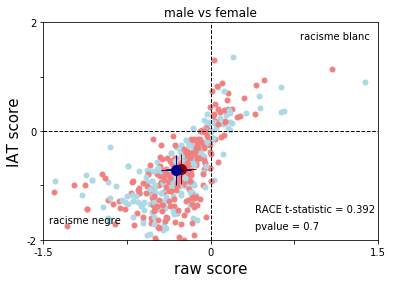

In [49]:
iat_scores = iat_race['IAT score'].values
iat_scores = iat_scores.astype(np.float)
genero_list = iat_race.genero.values

raw_uncorrected = iat_race['raw uncorrected'].values
raw_uncorrected = raw_uncorrected.astype(np.float)


plt.figure()

for i in range(len(iat_scores)):
    if genero_list[i]=='male':
        plt.plot(raw_uncorrected[i], iat_scores[i],marker='.', markersize=10, color='lightcoral' )
    if genero_list[i]=='female':
        plt.plot(raw_uncorrected[i], iat_scores[i],marker='.', markersize=10, color='lightblue' )

    
#
plt.xlim([-1.5,1.5])
plt.xticks([-1.5, -0.75, 0, 0.75, 1.5], ['-1.5', '', '0', '', '1.5'], fontsize=10)

plt.plot([-1.5, 1.5], [0,0], 'k--', linewidth=1)


plt.ylim([-2,2])
plt.yticks([-2,-1, 0, 1,2], ['-2','', '0', '','2'], fontsize=10)

plt.plot( [0,0], [-2,2], 'k--', linewidth=1)
plt.xlabel('raw score', fontsize=15)
plt.ylabel('IAT score', fontsize=15)



iat_scores_male = iat_race.loc[iat_race['genero']=='male', 'IAT score'].values.astype(np.float)
iat_scores_female = iat_race.loc[iat_race['genero']=='female', 'IAT score'].values.astype(np.float)

raw_uncorrected_male = iat_race.loc[iat_race['genero']=='male', 'raw uncorrected'].values.astype(np.float)
raw_uncorrected_female = iat_race.loc[iat_race['genero']=='female', 'raw uncorrected'].values.astype(np.float)

plt.plot(np.mean(raw_uncorrected_male), np.mean(iat_scores_male), marker='+', markersize=30, color='darkred' )
plt.plot(np.mean(raw_uncorrected_male), np.mean(iat_scores_male), marker='.', markersize=20, color='darkred' )

plt.plot(np.mean(raw_uncorrected_female), np.mean(iat_scores_female), marker='+', markersize=30, color='darkblue' )
plt.plot(np.mean(raw_uncorrected_female), np.mean(iat_scores_female), marker='.', markersize=20, color='darkblue' )


stats1 = stats.ttest_ind(iat_scores_male, iat_scores_female)

plt.text( 0.4, -1.5, 'RACE t-statistic = ' + str(np.round(stats1[0], 3)), fontsize=10 )

if stats1[1]<0.001:
    plt.text( 0.4, -1.8, 'pvalue <0.001', fontsize=10 )
else:
    plt.text( 0.4, -1.8, 'pvalue = ' +  str(np.round(stats1[1], 2)), fontsize=10 )


plt.text( 0.8, 1.7, 'racisme blanc' , fontsize=10 )
plt.text( -1.45, -1.7, 'racisme negre' , fontsize=10 )
plt.title('male vs female')

plt.show(block=False)


In [70]:
# # GET THE DATA

#iat_race=pd.read_csv(path_summary_file + 'summary_filex.csv')  


dat={} #store for summary stats. We use a dict because can be dynamically allocated
basis=np.zeros(2) # IAT race, RAW race,order variable

# COLLATE THE DATA

#iterate through all IAT race data
for i in range(0,len(iat_race)):
    #get filename
    #name_full=iat_race['code_file'].iloc[0]
    name= iat_race['file_code'] #name_full.split('_')[0]
    #from the filename we extract the ppt number
    ppt_number=i
    #creat a dict entry for that ppt
    ppt_dat=basis.copy()
    ppt_dat[0]=iat_race['IAT score'].values[i]
    ppt_dat[1]=iat_race['raw uncorrected'].values[i]
    dat[ppt_number]=ppt_dat


#now we can extract paired IAT scores
            
IATrace=[]  
RAWrace=[]
            
for key in dat:
    IATrace.append(dat[key][0])              
    RAWrace.append(dat[key][1])              



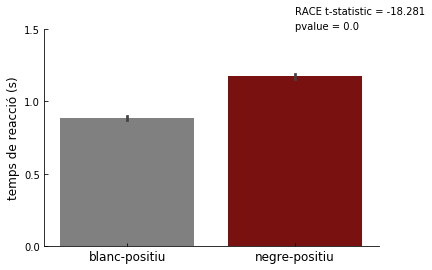

Ttest_relResult(statistic=-18.281496461433424, pvalue=1.5080255269664808e-56)


In [72]:
########### REACTION TIMES

c_ = iat_race['congruent mean RT'].values
c_adj = iat_race['congruent adjmean RT'].values
congruent = pd.DataFrame({'reaction time': c_, 'reaction time adj': c_adj})
congruent['condition'] = 'congruent'


i_ = iat_race['incongruent mean RT'].values
i_adj = iat_race['incongruent adjmean RT'].values
incongruent = pd.DataFrame({'reaction time': i_,  'reaction time adj': i_adj})
incongruent['condition'] = 'incongruent'


reaction_time = pd.concat([congruent, incongruent])
#reaction_time['reaction time'] =  reaction_time['reaction time'].astype(float)

plt.figure()
sns.barplot(x='condition', y='reaction time', palette=['grey', 'darkred'], ci=68, estimator=np.mean, data=reaction_time)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.ylim(0,1.5)
plt.yticks([0,0.5,1,1.5])
plt.ylabel('temps de reacció (s)', fontsize=12)
plt.xlabel('')
plt.xticks([0,1], ['blanc-positiu', 'negre-positiu'], fontsize=12)
stats2 = scipy.stats.ttest_rel(c_, i_)
plt.text( 1, 1.6, 'RACE t-statistic = ' + str(np.round(stats2[0], 3)), fontsize=10 )
plt.text( 1, 1.5, 'pvalue = ' + str(np.round(stats2[1], 3)), fontsize=10 )
plt.show(block=False)
print(stats2)


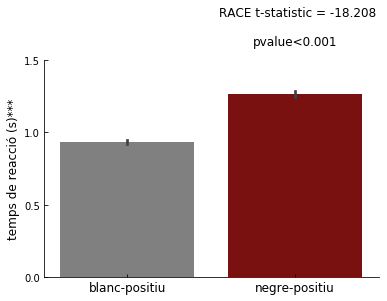

Ttest_relResult(statistic=-18.207889185773535, pvalue=3.296847722297689e-56)


In [73]:

plt.figure()
sns.barplot(x='condition', y='reaction time adj', palette=['grey', 'darkred'], ci=68, estimator=np.mean, data=reaction_time)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.ylim(0,1.5)
plt.yticks([0,0.5,1,1.5])
plt.ylabel('temps de reacció (s)***', fontsize=12)
plt.xlabel('')
plt.xticks([0,1], ['blanc-positiu', 'negre-positiu'], fontsize=12)
stats3 = scipy.stats.ttest_rel(c_adj, i_adj)
plt.text( 0.55, 1.8, 'RACE t-statistic = ' + str(np.round(stats3[0], 3)), fontsize=12 )
#plt.text( 0.5, 1.5, 'pvalue = ' + str(np.round(stats3[1], 3)), fontsize=10 )
plt.text( 0.75, 1.6, 'pvalue<0.001', fontsize=12)
plt.savefig('biblios.png', transparent=True)
plt.show(block=False)

print(stats3)
